<a href="https://colab.research.google.com/github/jehee-lee/Aerospace_capstone_design/blob/main/%EC%8B%A4%EC%8A%B5_3)_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5%EC%9C%BC%EB%A1%9C_%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5(target_%3D_position).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

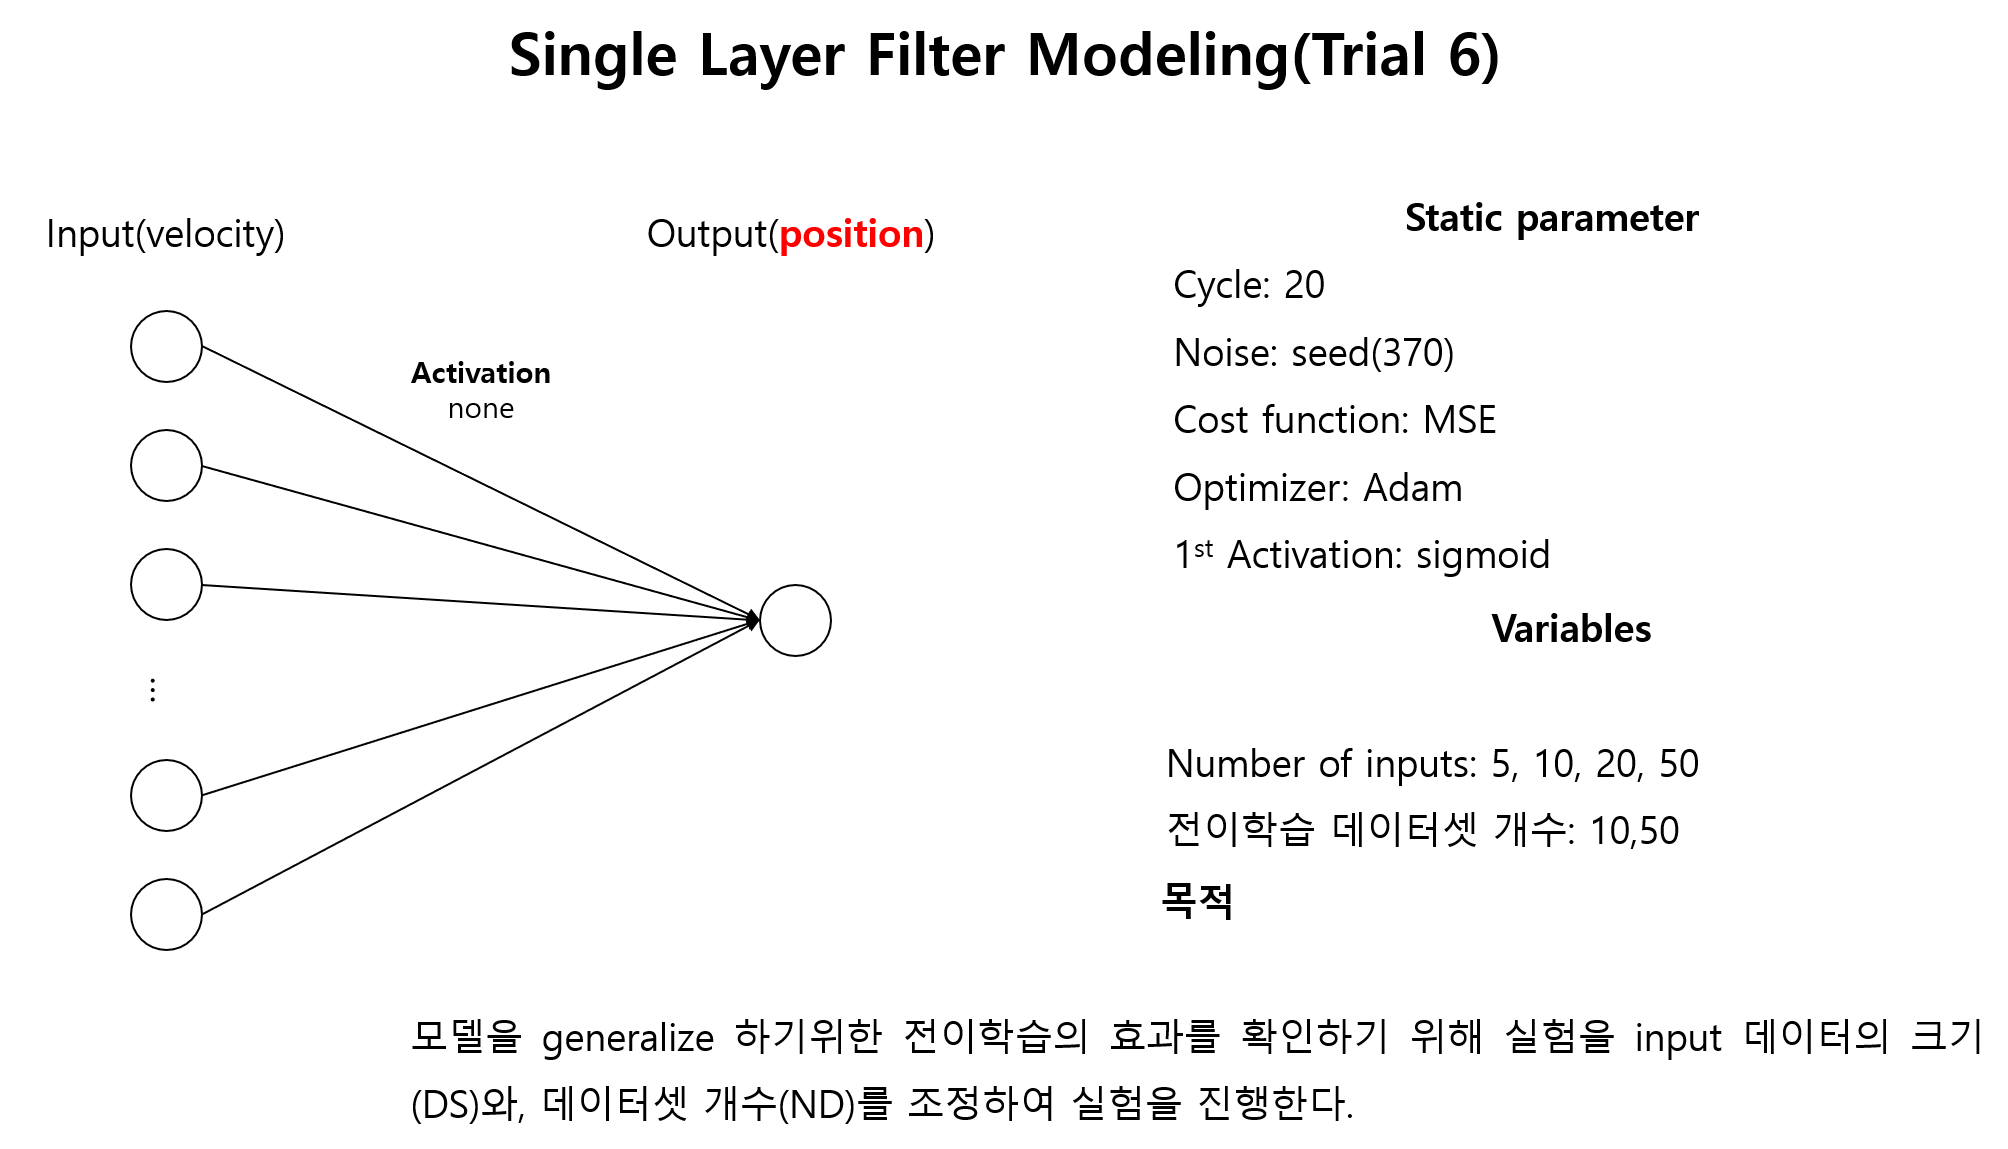

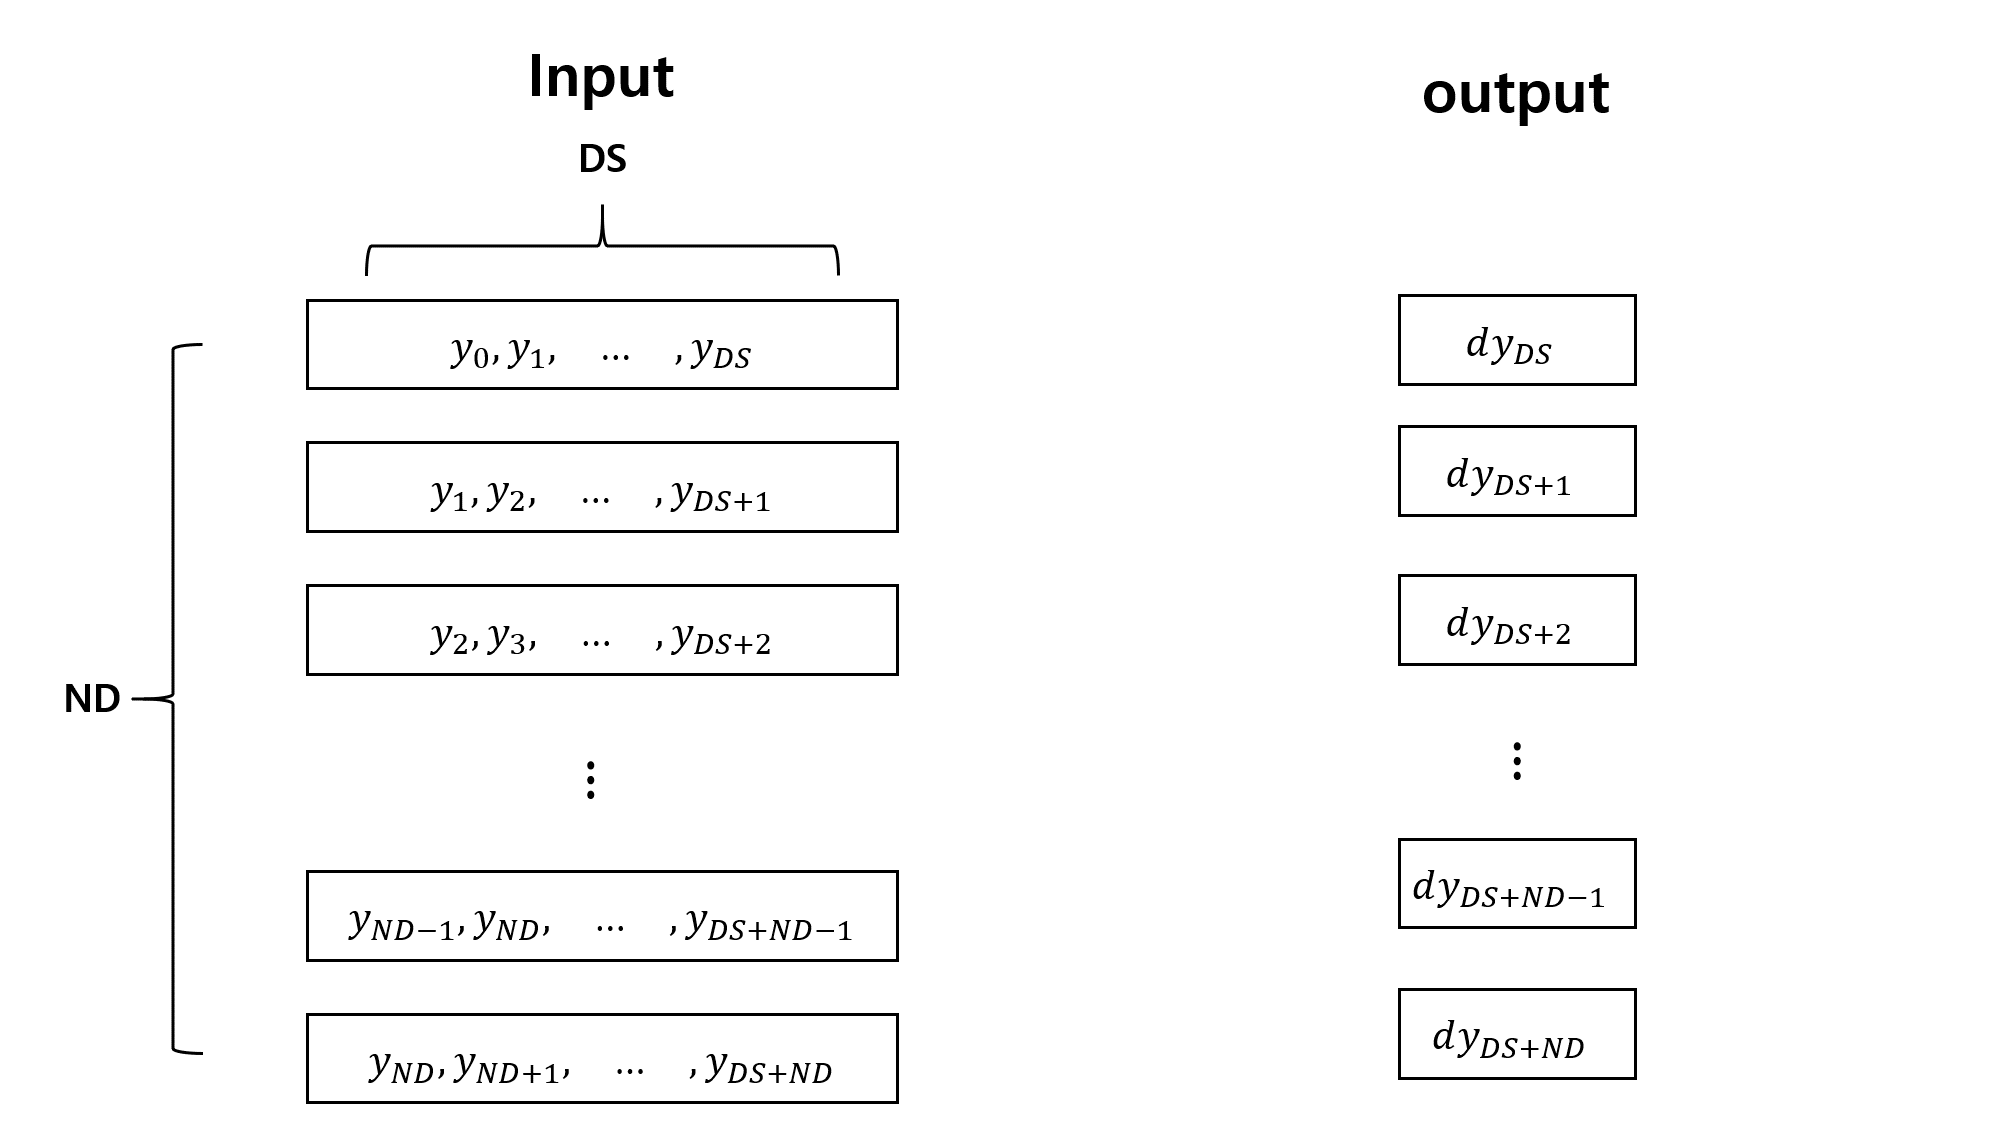

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

#실험 조건, 데이터 사이즈 설정

N = 1000 #number of timesteps

x = np.zeros((2,N+1))
x[:,0]=[0,0]
y = np.zeros((1,N))

T=50 #time will vary from 0 to T with step delt
ts = np.linspace(0, T, N+1)
del_t = T/N # delta_t = 0.05 = 50 / 1000
gamma = 0.05 #damping

#정규분포 노이즈 생성
np.random.seed(370)
w = np.random.randn(1,N)
n = np.random.randn(1,N)

# X행렬 구성성분
A[0,0] = 1
A[0,1] = (1-gamma*del_t/2)*del_t
A[1,1] = 1 - gamma*del_t

B[0,0] = del_t**2/2
B[1,0] = del_t

C[0,0] = 1

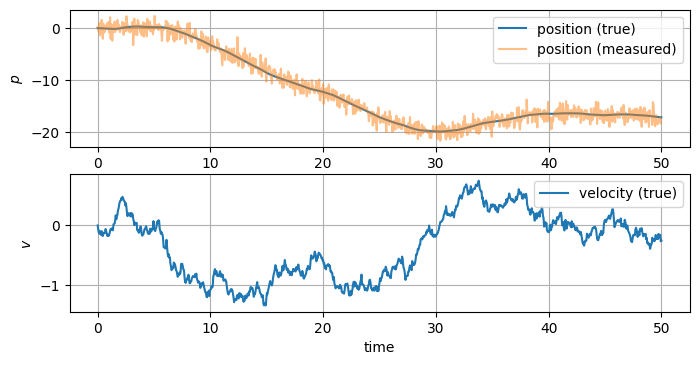

In [2]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])

x_true = x.copy()

plt.figure(figsize=(8,4), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

#학습에 사용할 input의 사이즈 지정

DS = 50 부터 실행


<Figure size 800x300 with 0 Axes>

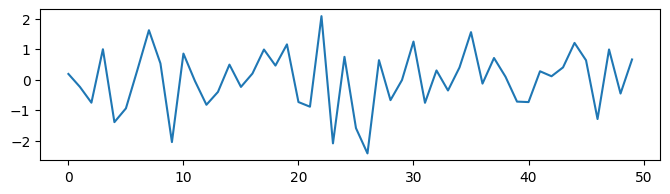

In [3]:
#학습할 데이터 사이즈(number of inputs)
DS = 50

train_input = np.zeros((1,DS))
#데이터 사이즈 만큼 계측 데이터 Y를 불러옴
plt.figure(figsize=(8,3), dpi=100)


train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,50])

#학습할 데이터셋의 개수
ND = 50
for i in range(49):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
#target 지정
train_target = x[0,1+DS:DS+ND+1].copy()
plt.figure(figsize=(8,2), dpi=100)
plt.plot(train_input[0,:])
plt.show()

In [4]:
train_input.shape, train_target.shape

((50, 50), (50,))

데이터 크기(DS) 가 50인 데이터가 50개(DN) 생겼다.

In [5]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


50개의 데이터셋을 전이학습하여 genaralize 한다.

In [6]:
#50개의 데이터셋을 한 바퀴 학습한 것을 1cycle로 한다
cycle = 20

for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 6.0343 - mae: 2.4565 - mse: 6.0343
              2 번째 cycle
1/1 [==============================] - 0s 12ms/step - loss: 5.3355 - mae: 2.3099 - mse: 5.3355
              3 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 4.7040 - mae: 2.1689 - mse: 4.7040
              4 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 4.1353 - mae: 2.0335 - mse: 4.1353
              5 번째 cycle
1/1 [==============================] - 0s 8ms/step - loss: 3.6249 - mae: 1.9039 - mse: 3.6249
              6 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 3.1684 - mae: 1.7800 - mse: 3.1684
              7 번째 cycle
1/1 [==============================] - 0s 4ms/step - loss: 2.7617 - mae: 1.6618 - mse: 2.7617
              8 번째 cycle
1/1 [==============================] - 0s 11ms/step - loss: 2.4006 - mae: 1.5494 - mse: 2.4006
              9 번째 cycle
1/1 [================

In [7]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


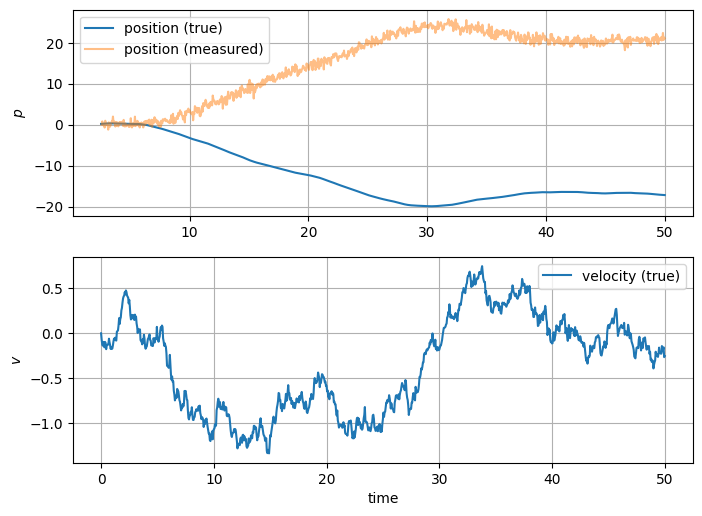

In [8]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

다음에 대해 추가적으로 실험 진행

ND = 10

In [10]:
DS ,ND = 50, 10
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = x[0,1+DS:DS+ND+1].copy()

In [11]:
train_input.shape

(10, 50)

In [12]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_dim=DS)])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

In [13]:
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 10ms/step - loss: 0.6963 - mae: 0.8345 - mse: 0.6963
              2 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.6687 - mae: 0.8178 - mse: 0.6687
              3 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.6376 - mae: 0.7985 - mse: 0.6376
              4 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.6066 - mae: 0.7789 - mse: 0.6066
              5 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.5767 - mae: 0.7594 - mse: 0.5767
              6 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.5482 - mae: 0.7404 - mse: 0.5482
              7 번째 cycle
1/1 [==============================] - 0s 12ms/step - loss: 0.5211 - mae: 0.7219 - mse: 0.5211
              8 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.4953 - mae: 0.7038 - mse: 0.4953
              9 번째 cycle
1/1 [================

In [14]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


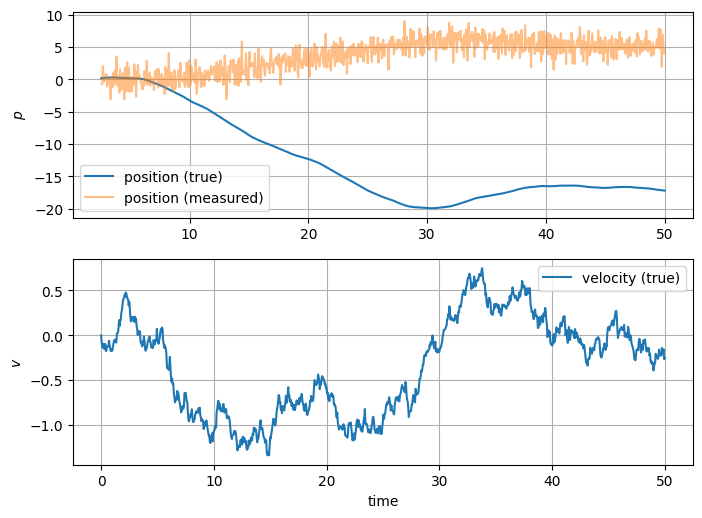

In [15]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

dataset의 개수(ND)가 감소하였을 때 정확도가 그나마 더 나아졌다.

ND = 50일 때 과적합이 심했음을 알 수 있다.

데이더의 크기(DS)가 20일 때

In [23]:
DS ,ND = 20, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = x[0,1+DS:DS+ND+1].copy()

In [24]:
train_input.shape, train_target.shape

((50, 20), (50,))

In [25]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_dim=DS)])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

In [26]:
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 1.2700 - mae: 1.1270 - mse: 1.2700
              2 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 1.0113 - mae: 1.0056 - mse: 1.0113
              3 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.7899 - mae: 0.8888 - mse: 0.7899
              4 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.6050 - mae: 0.7778 - mse: 0.6050
              5 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.4531 - mae: 0.6731 - mse: 0.4531
              6 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.3305 - mae: 0.5749 - mse: 0.3305
              7 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.2335 - mae: 0.4832 - mse: 0.2335
              8 번째 cycle
1/1 [==============================] - 0s 9ms/step - loss: 0.1583 - mae: 0.3979 - mse: 0.1583
              9 번째 cycle
1/1 [==================

In [27]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


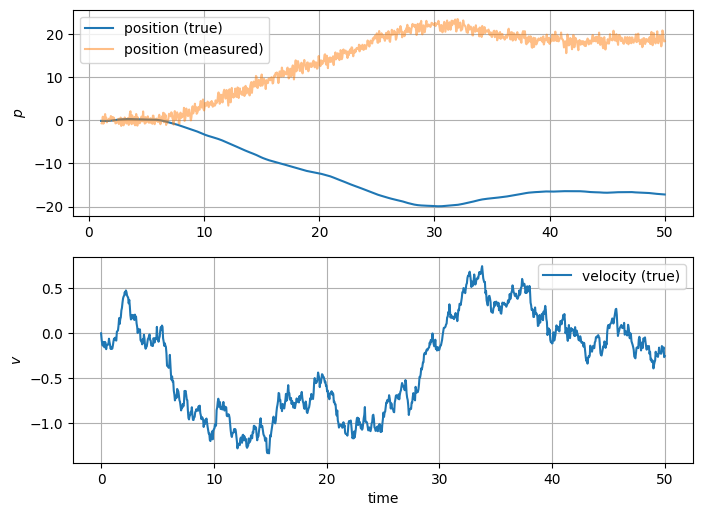

In [28]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

ND가 증가하자 ND,DS와 비슷한 양상을 보인다.

In [38]:
DS ,ND = 20, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = x[0,1+DS:DS+ND+1].copy()

In [39]:
train_input.shape

(50, 20)

In [40]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_dim=DS)])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

In [41]:
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 7ms/step - loss: 1.6519 - mae: 1.2853 - mse: 1.6519
              2 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 1.5038 - mae: 1.2263 - mse: 1.5038
              3 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 1.3658 - mae: 1.1687 - mse: 1.3658
              4 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 1.2376 - mae: 1.1125 - mse: 1.2376
              5 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 1.1187 - mae: 1.0577 - mse: 1.1187
              6 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 1.0086 - mae: 1.0043 - mse: 1.0086
              7 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9069 - mae: 0.9523 - mse: 0.9069
              8 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.8131 - mae: 0.9017 - mse: 0.8131
              9 번째 cycle
1/1 [==================

In [43]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


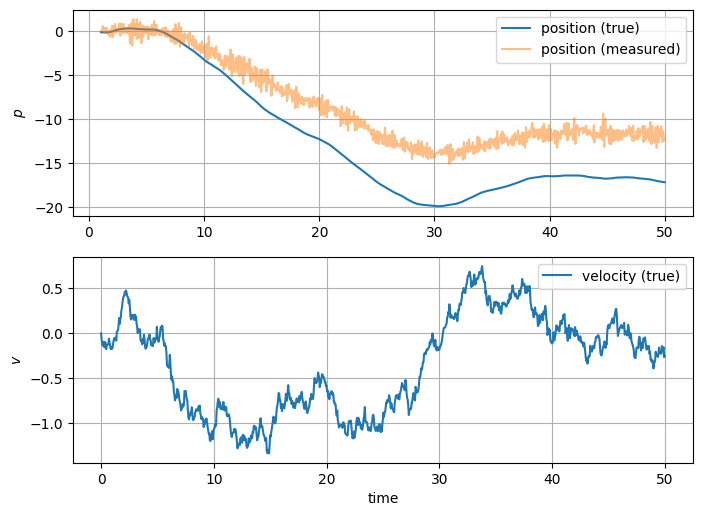

In [51]:
output = np.reshape(output,(1,1000))
plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

DS  를 20으로 줄이니
오차가 더 줄어든 듯 하다

In [60]:
DS ,ND = 20, 10
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = x[0,1+DS:DS+ND+1].copy()

In [61]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_dim=DS)])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

In [62]:
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9447 - mae: 0.9719 - mse: 0.9447
              2 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.9040 - mae: 0.9508 - mse: 0.9040
              3 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.8606 - mae: 0.9277 - mse: 0.8606
              4 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.8179 - mae: 0.9044 - mse: 0.8179
              5 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.7767 - mae: 0.8813 - mse: 0.7767
              6 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.7374 - mae: 0.8587 - mse: 0.7374
              7 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.6999 - mae: 0.8366 - mse: 0.6999
              8 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.6642 - mae: 0.8150 - mse: 0.6642
              9 번째 cycle
1/1 [==================

In [63]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


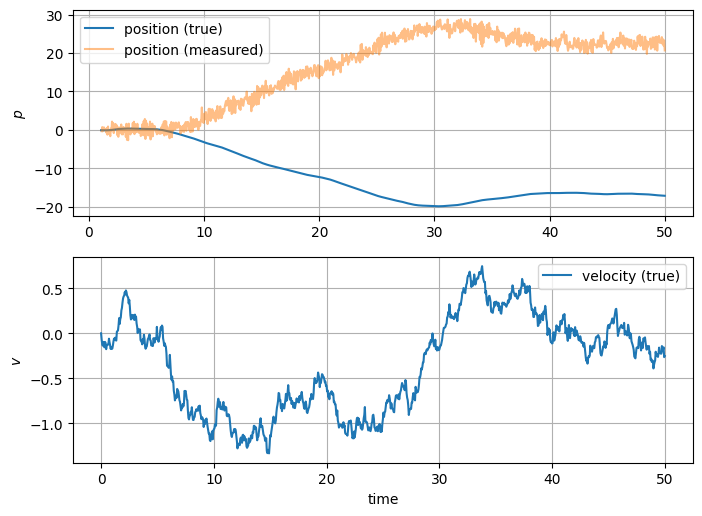

In [64]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

ND 가 감소하니 DS, ND = 50, 10과 같은 양상

DS = 10으로 실행

In [65]:
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = x[0,1+DS:DS+ND+1].copy()

In [66]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_dim=DS)])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

In [67]:
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 7ms/step - loss: 0.4107 - mae: 0.6409 - mse: 0.4107
              2 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.3915 - mae: 0.6257 - mse: 0.3915
              3 번째 cycle
1/1 [==============================] - 0s 7ms/step - loss: 0.3725 - mae: 0.6103 - mse: 0.3725
              4 번째 cycle
1/1 [==============================] - 0s 7ms/step - loss: 0.3535 - mae: 0.5946 - mse: 0.3535
              5 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.3346 - mae: 0.5784 - mse: 0.3346
              6 번째 cycle
1/1 [==============================] - 0s 8ms/step - loss: 0.3158 - mae: 0.5619 - mse: 0.3158
              7 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.2970 - mae: 0.5450 - mse: 0.2970
              8 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.2785 - mae: 0.5278 - mse: 0.2785
              9 번째 cycle
1/1 [==================

In [68]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


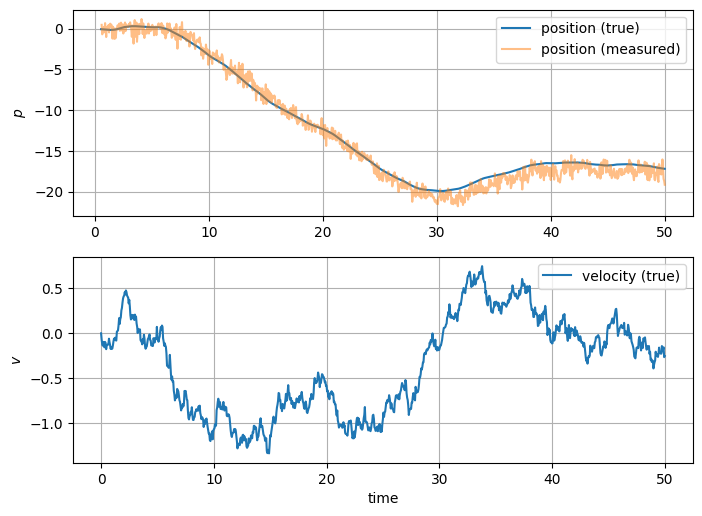

In [69]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

DS, ND = 10,50 은 지금껏 나온 모델 중 가장 정확도가 높다.

In [71]:
DS ,ND = 10, 10
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = x[0,1+DS:DS+ND+1].copy()

In [72]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_dim=DS)])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

In [73]:
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 1.0169 - mae: 1.0084 - mse: 1.0169
              2 번째 cycle
1/1 [==============================] - 0s 11ms/step - loss: 0.9941 - mae: 0.9970 - mse: 0.9941
              3 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9702 - mae: 0.9850 - mse: 0.9702
              4 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.9463 - mae: 0.9728 - mse: 0.9463
              5 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9226 - mae: 0.9605 - mse: 0.9226
              6 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.8993 - mae: 0.9483 - mse: 0.8993
              7 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.8763 - mae: 0.9361 - mse: 0.8763
              8 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.8538 - mae: 0.9240 - mse: 0.8538
              9 번째 cycle
1/1 [=================

In [74]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


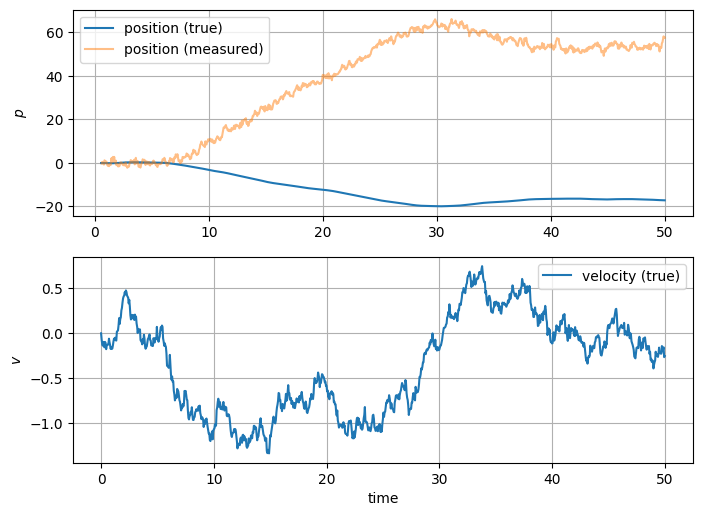

In [75]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

ND가 감소하니 모델이 다시 이상해졌다.

In [76]:
DS ,ND = 5, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = x[0,1+DS:DS+ND+1].copy()

In [77]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_dim=DS)])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

In [78]:
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9496 - mae: 0.9745 - mse: 0.9496
              2 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9441 - mae: 0.9717 - mse: 0.9441
              3 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9387 - mae: 0.9689 - mse: 0.9387
              4 번째 cycle
1/1 [==============================] - 0s 7ms/step - loss: 0.9330 - mae: 0.9659 - mse: 0.9330
              5 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9269 - mae: 0.9628 - mse: 0.9269
              6 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9202 - mae: 0.9593 - mse: 0.9202
              7 번째 cycle
1/1 [==============================] - 0s 7ms/step - loss: 0.9130 - mae: 0.9555 - mse: 0.9130
              8 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.9053 - mae: 0.9515 - mse: 0.9053
              9 번째 cycle
1/1 [==================

In [79]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


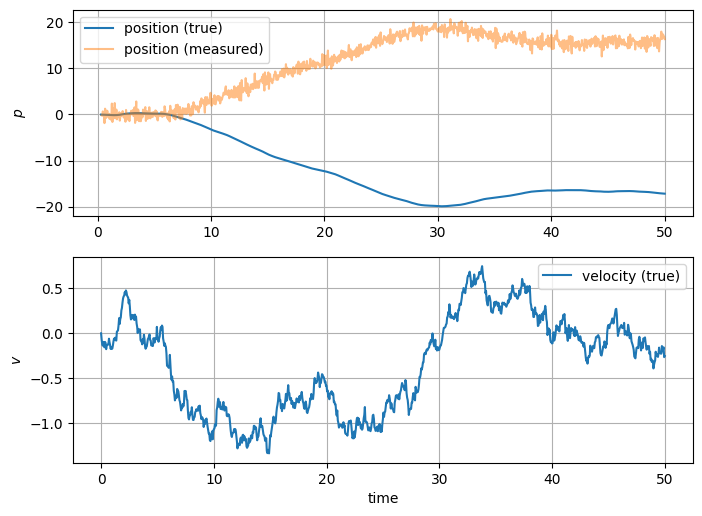

In [80]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

In [83]:
DS ,ND = 5, 10
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = x[0,1+DS:DS+ND+1].copy()

In [84]:
#모델 만들기
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_dim=DS)])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])

In [85]:
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    model.fit(input, target,epochs = 1)

              1 번째 cycle
1/1 [==============================] - 0s 8ms/step - loss: 0.8483 - mae: 0.9210 - mse: 0.8483
              2 번째 cycle
1/1 [==============================] - 0s 7ms/step - loss: 0.8471 - mae: 0.9204 - mse: 0.8471
              3 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.8455 - mae: 0.9195 - mse: 0.8455
              4 번째 cycle
1/1 [==============================] - 0s 7ms/step - loss: 0.8436 - mae: 0.9185 - mse: 0.8436
              5 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.8417 - mae: 0.9174 - mse: 0.8417
              6 번째 cycle
1/1 [==============================] - 0s 6ms/step - loss: 0.8397 - mae: 0.9164 - mse: 0.8397
              7 번째 cycle
1/1 [==============================] - 0s 5ms/step - loss: 0.8376 - mae: 0.9152 - mse: 0.8376
              8 번째 cycle
1/1 [==============================] - 0s 9ms/step - loss: 0.8355 - mae: 0.9140 - mse: 0.8355
              9 번째 cycle
1/1 [==================

In [86]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


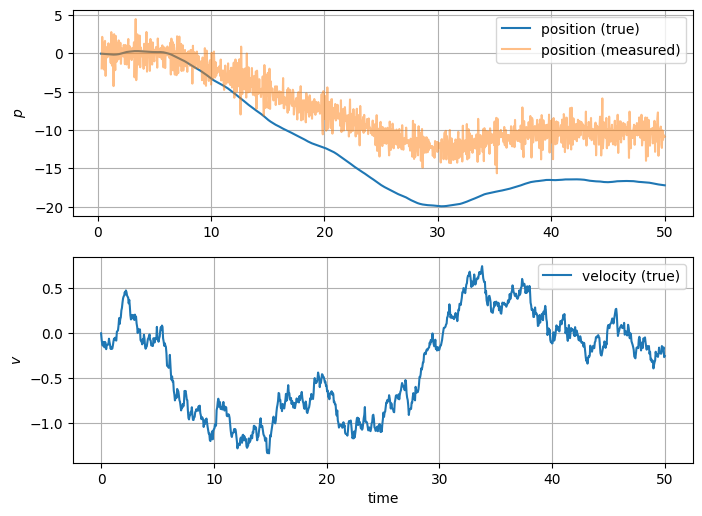

In [87]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()